In [1]:
import pandas as pd
import numpy as np
import json
import os
import string
import re
import random

import nltk
from nltk import word_tokenize
from nltk.corpus import (wordnet, stopwords)
from nltk.stem.snowball import SnowballStemmer

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

from sklearn.linear_model import (LogisticRegression, LogisticRegressionCV)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (confusion_matrix, 
                             recall_score, 
                             f1_score, 
                             accuracy_score, 
                             precision_score,
                             roc_curve, auc, roc_auc_score)

import warnings
warnings.filterwarnings('ignore')

from datetime import *
from bisect import bisect

In [2]:
##### Functions to parse the time
def parse_datetime(raw_datetime, dtformat):
    if len(raw_datetime)<5:
        return np.nan, 365, np.nan, np.nan    
    datetime_obj = datetime.strptime(raw_datetime,dtformat) 
    return datetime_obj.hour

def bizhour(hh):
    biz = ['Late','Early','Business','Evening', 'Late']
    breakpoints = [5, 10, 17,20]
    return biz[bisect(breakpoints, hh)]

def get_descr_bizhour(hhmat):
    return np.array(list(map(bizhour, hhmat)))

In [3]:
#Karthik's code
class RepeatReplacer(object):
    """ Removes repeating characters until a valid word is found.
    >>> replacer = RepeatReplacer()
    >>> replacer.replace(‘looooove’)
    ‘love’
    >>> replacer.replace(‘oooooh’)
    ‘ooh’
    >>> replacer.replace(‘goose’)
    ‘goose’
    """

    def __init__(self):
        self.repeat_regexp = re.compile(r'(\w*)(\w)\2(\w*)')
        self.repl = r'\1\2\3'

    def replace(self, word):
        if wordnet.synsets(word):
            return word

        repl_word = self.repeat_regexp.sub(self.repl, word)

        if repl_word != word:
            return self.replace(repl_word)
        else:
            return repl_word
    
    
def process_tweets (tweets, textcol):
    processed_text = []
    for text in tweets[textcol]:
        #replace hyperlinks - leaves xa0 off for some reason
        test = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', ' hyperlink ', text).replace('\xa0', '')
        #replace mentions
        test = re.sub(r'(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9]+)', ' mention ', test)
        #replace picture links
        test = re.sub(r'pic.twitter\S+', ' image ', test)
        test = "".join((char for char in test if char not in string.punctuation + '—–-…’0123456789')).lower()\

        #remove repeat letters
        tokens = [RepeatReplacer().replace(w) for w in word_tokenize(test)]
        #employ stemmer
        stemmer = SnowballStemmer("english")
        tokens = [stemmer.stem(w) for w in tokens]
        #get rid of stop words
        filtered_string = ' '.join([w for w in tokens
                             if not w in set(stopwords.words('english'))])

        processed_text.append(filtered_string)

    tweets[textcol] = processed_text
    
    return tweets

    tf = TfidfVectorizer(analyzer='word', min_df = 15, stop_words = 'english')

    tfidf_matrix =  tf.fit_transform(tweets[textcol])
    feature_names = tf.get_feature_names() 
    dense = tfidf_matrix.todense()
    df = pd.DataFrame(dense)
    df.columns = feature_names
    
    return df

def sentiment_analysis(text):
    analyzer = SentimentIntensityAnalyzer()
    neg = []
    neu = []
    pos = []
    for sentence in text:
        vs = analyzer.polarity_scores(sentence)
        neg.append(vs['neg'])
        neu.append(vs['neu'])
        pos.append(vs['pos'])
    return neg, pos, neu

def safe_div(x,y):
    if y == 0:
        return 0
    return x / y

In [4]:
jsons_data = pd.DataFrame()

directory = '/Users/jenniferpolson/Documents/School/2018-W/BE 223B/Project 1/tweet_files-1/'
for filename in os.listdir(directory):
    if filename.endswith('.json'):
        df = pd.DataFrame(json.load(open(directory + str(filename))))
        df['tweet_id'] = df['user_record_id'].map(str) + '_' + df.index.astype(str)
        jsons_data = jsons_data.append(df) 

#jsons_data['Negative Sentiment'], jsons_data['Positive Sentiment'], jsons_data['Neutral Sentiment'] = sentiment_analysis(jsons_data['text'])
#jsons_data = jsons_data[jsons_data['Neutral Sentiment'] != 1]

## Jen Attempt 2

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import numpy as np

def display_topics(H, W, feature_names, documents, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        #for doc_index in top_doc_indices:
        #    print (documents[doc_index])

documents = jsons_data.text

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(documents)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
tf = tf_vectorizer.fit_transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names()

no_topics = 20

# Run NMF
nmf_model = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
nmf_W = nmf_model.transform(tfidf)
nmf_H = nmf_model.components_

# Run LDA
lda_model = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)
lda_W = lda_model.transform(tf)
lda_H = lda_model.components_

no_top_words = 8
no_top_documents = 4
display_topics(nmf_H, nmf_W, tfidf_feature_names, documents, no_top_words, no_top_documents)
display_topics(lda_H, lda_W, tf_feature_names, documents, no_top_words, no_top_documents)

Topic 0:
status twitter com https shashaaa23 absurdistwords ctfu 2door_porsh
Topic 1:
instagram www https com photo posted mood night
Topic 2:
pic twitter com http tt ift hey cute
Topic 3:
don want think need wanna say cause time
Topic 4:
fb http youtube video youtu added playlist new
Topic 5:
thank yu god menaict2016 menaict awesome baby appreciate
Topic 6:
lol crazy yeah yes yu need okay oh
Topic 7:
like feel look looks sleep act going said
Topic 8:
love ain yu let fall secret life vixx
Topic 9:
just wanna posted photo want ll thought said
Topic 10:
bit ly http today gemini a9q3zb cancer yk3b9m
Topic 11:
people black white person automatically fllwrs checked followed
Topic 12:
know yu let didn wanna damaged going getting
Topic 13:
got want ve night ain need time ya
Topic 14:
good morning times looks feel luck yall job
Topic 15:
really doe did need life job son bad
Topic 16:
shit real ain fuck nigga star hot dumb
Topic 17:
right make literally gotta feel real wanna situation
Topic 18:

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import numpy as np

def display_topics(H, W, feature_names, documents, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        #for doc_index in top_doc_indices:
        #    print (documents[doc_index])

#df = process_tweets(jsons_data, 'text')
#documents = df.text
documents = jsons_data.text

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
tf = tf_vectorizer.fit_transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names()

no_topics = 20

# Run LDA
lda_model = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)
lda_W = lda_model.transform(tf)
lda_H = lda_model.components_

n_top_words = 8
n_top_documents = 4
display_topics(lda_H, lda_W, tf_feature_names, documents, n_top_words, n_top_documents)

Topic 0:
don like just love know people want make
Topic 1:
ll money use pay poor realize taking justice
Topic 2:
baby live everybody tv needs text kno gets
Topic 3:
game damn niggas 10 play smh high lil
Topic 4:
right thank thanks wit classes racism sis racist
Topic 5:
black going face year watch tonight fucking girl
Topic 6:
good ve bad oh thought world yeah just
Topic 7:
gotta yes things women mind justin literally level
Topic 8:
think lol learn new sure used favorite fun
Topic 9:
pic got people time didn person ain just
Topic 10:
shit way like man long potus speak days
Topic 11:
http bit ly today week open continue 2016
Topic 12:
callisti2024 03 military book dude sexual signals tuesday
Topic 13:
wait read won tell ok school buy watching
Topic 14:
really let getting hate bitches children job away
Topic 15:
need life real ya 2017 nigga yu gone
Topic 16:
thing fb doing hard house looking answer power
Topic 17:
com twitter https status www instagram arabic http
Topic 18:
america child 

In [7]:
cols = []
for n in np.arange(no_topics):
    cols.append('LDA_%d' % n)

In [8]:
all_data = pd.concat([jsons_data, pd.DataFrame(lda_W, index = jsons_data.index, columns = cols) ], axis = 1)

tweets_concat = pd.DataFrame()

for tid in all_data.user_record_id.unique():
    df = all_data.loc[all_data['user_record_id'] == tid]
    wk_list = df.weekday.tolist()
    n_tweets = len(df.index)

    hours = np.zeros(len(df.index))

    for i,rd in enumerate(df['time']):
        hours[i]=parse_datetime(rd,'%H:%M:%S')

    timeofday = list(get_descr_bizhour(hours))

    tweets_concat = tweets_concat.append({'n_tweets': n_tweets,
                                          'text':df['text'].str.cat(sep=', '), 
                                          'likes':df.likes.astype(int).sum(), 
                                          'replies':df.replies.astype(int).sum(), 
                                          'retweets':df.retweets.astype(int).sum(), 
                                          'weekday_mean': df.weekday.astype(int).mean(),
                                          'wkday_0': wk_list.count(0)/n_tweets,
                                          'wkday_1': wk_list.count(1)/n_tweets,
                                          'wkday_2': wk_list.count(2)/n_tweets,
                                          'wkday_3': wk_list.count(3)/n_tweets,
                                          'wkday_4': wk_list.count(4)/n_tweets,
                                          'wkday_5': wk_list.count(5)/n_tweets,
                                          'wkday_6': wk_list.count(6)/n_tweets,
                                          'time_late': timeofday.count('Late')/n_tweets,
                                          'time_early': timeofday.count('Early')/n_tweets,
                                          'time_business': timeofday.count('Business')/n_tweets,
                                          'time_evening': timeofday.count('Evening')/n_tweets,
                                          'user_id':df.user_record_id.iloc[0]}, ignore_index = True)

for topic in cols:
    tweets_concat[topic] = all_data.groupby(['user_record_id'])[topic].mean().tolist()
    
tweets_concat.to_csv('tweets_concatenated.csv')

In [9]:
def create_model_df (tweets, labels, 
                     textcol = 'text', idcol = 'user_id', 
                     repcol = 'replies', lcol = 'likes', retcol = 'retweets', 
                     bincol = 'variable'):
    df = process_tweets(tweets, textcol)
    #generate tfidf, concatenate with processed tweets
    #new_features = pd.concat([df, tfidf_vector(df, textcol)], axis = 1)
    new_features = df
    new_features.index = new_features[idcol]
    #generate sentiment
    new_features['Negative Sentiment'], new_features['Positive Sentiment'], new_features['Neutral Sentiment'] = sentiment_analysis(tweets[textcol])
    #match and merge with labels
    full_data = pd.merge(new_features, labels, how='inner', on=None, left_on=None, right_on=None,
                         left_index=True, right_index=True).drop([idcol], axis=1)

    ratio = []
    for index, row in full_data.iterrows():
        div = safe_div(row[repcol], (row[lcol] + row[retcol]))
        ratio.append(div)

    full_data['ratio'] = ratio
    #this gets rid of duplicate columns
    full_data = full_data.loc[:,~full_data.columns.duplicated()]
    #binarize
    full_data['binary_label'] = (full_data[bincol] >= 3).astype(int)
    #full_data = full_data.drop(full_data[full_data.variable == 3].index)
    
    return full_data

In [10]:
#split into folds
def create_folds(full_data, n): 
    nlist = list(range(0,len(full_data)-1))
#    random.seed(16)
    random.shuffle(nlist)
    fold_size = len(nlist) / n
    ints = [nlist[int(round(fold_size * i)): 
                  int(round(fold_size * (i + 1)))] 
             for i in range(n)]
    fold = [full_data.iloc[ints[i],:] for i in range(n)]
    return fold

def binary_metrics (test, label, pred):
    acc = accuracy_score(test[label], test[pred])
    f1 = f1_score(test[label], test[pred])
    prec = precision_score(test[label], test[pred])
    rec = recall_score(test[label], test[pred])
    roc_auc = roc_auc_score(test[label], test[pred])
    
    tn, fp, fn, tp = confusion_matrix(test[label], test[pred]).ravel()
    
    return roc_auc, acc, prec, rec, f1

def rfc_metrics (test, label, pred):
    tn, fp, fn, tp = confusion_matrix(test[label], test[pred]).ravel()
    
    roc_auc, acc, prec, rec, f1 = binary_metrics(test, label, pred)
    
    roc = roc_curve(test[label], test[pred])
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = test[label].nunique()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(test[label], test[pred])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(test[label].ravel(), test[pred].ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure(figsize=(8,5))
    lw = 2
    plt.plot(fpr[1], tpr[1], color='gold',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Example')
    plt.legend(loc="lower right")
    plt.show()
    
    show_confusion_matrix(test, label, pred)
    
    return details

def show_confusion_matrix(test, label, pred):
    
    C = confusion_matrix(test[label], test[pred])
    tn, fp, fn, tp = C.ravel()
    
    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)


    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(['Show', 'No Show'])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(['Show', 'No Show'])
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)


    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,'True Negatives: %d\n(Total Negatives: %d)'%(tn,NN),
            va='center', ha='center', bbox=dict(fc='w',boxstyle='round,pad=1'))
    ax.text(0,1,'False Negatives: %d'%fn,
            va='center', ha='center', bbox=dict(fc='w',boxstyle='round,pad=1'))
    ax.text(1,0,'False Positives: %d'%fp,
           va='center', ha='center', bbox=dict(fc='w',boxstyle='round,pad=1'))
    ax.text(1,1,'True Positives: %d\n(Total Positives: %d)'%(tp,NP),
            va='center', ha='center', bbox=dict(fc='w',boxstyle='round,pad=1'))
    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,'True Negative Rate' + '\n' +'(Specificity):%.2f'%(tn / (fp+tn+0.)),
            va='center', ha='center', bbox=dict(fc='w',boxstyle='round,pad=1'))
    ax.text(2,1,'True Positive Rate' + '\n' + '(Sensitivity):%.2f'%(tp / (tp+fn+0.)),
            va='center', ha='center', bbox=dict(fc='w',boxstyle='round,pad=1'))
    ax.text(2,2,'F-1 Score: %.2f'%(round(2*tp/((2*tp) + fp + fn),3)),
            va='center', ha='center', bbox=dict(fc='w',boxstyle='round,pad=1'))
    ax.text(0,2,'Negative Predictive ' + '\n' + 'Value: %.2f'%(1-fn/(fn+tn+0.)),
           va='center', ha='center', bbox=dict(fc='w',boxstyle='round,pad=1'))
    ax.text(1,2,'Positive Predictive ' + '\n' + 'Value: %.2f'%(tp/(tp+fp+0.)),
            va='center', ha='center', bbox=dict(fc='w',boxstyle='round,pad=1'))
    plt.tight_layout()
    plt.show()
    
    return None

def run_model_lr(full, test, label, pred, plot = False, CV = False):
    train = pd.concat([full, test]).drop_duplicates(keep=False)
    trainArr = train.drop(['variable', 'binary_label'], axis = 1).as_matrix()
    trainRes = train.as_matrix(['binary_label'])
    testArr = test.drop(['variable', 'binary_label'], axis = 1).as_matrix()
    
    if CV:
        lr = LogisticRegressionCV(scoring = 'roc_auc')
        lr.fit(trainArr, trainRes)
        lr.fit(trainArr, trainRes)
        predictions = lr.predict(testArr)
        
    else:
    #gridsearch
        param_test1 = {'C':[0.0001,0.001,0.01,0.1,1,10,100,1000],
                       'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
                      }
        gridsearch = GridSearchCV(estimator = LogisticRegression(class_weight = 'balanced'),
                                  param_grid = param_test1, scoring = 'roc_auc')

        gridsearch.fit(trainArr,trainRes)

        lr = LogisticRegression(C=list(gridsearch.best_params_.values())[0],
                                    solver=list(gridsearch.best_params_.values())[1])

        lr.fit(trainArr, trainRes) 
        predictions = lr.predict(testArr)
        
    data = pd.DataFrame(list(test[label]),columns=[label], index = test.index)
    data[pred] = pd.Series(list(predictions), index=data.index)                
    
    if plot:
        roc_auc, acc, prec, rec, f1 = rfc_metrics(data, label, pred)
    else:
        roc_auc, acc, prec, rec, f1 = binary_metrics(data, label, pred)
    
    return data, [roc_auc, acc, prec, rec, f1]

In [11]:
def run_model_rfc (full, test, label, pred, plot = False):
    train = pd.concat([full, test]).drop_duplicates(keep=False)
    trainArr = train.drop(['variable', 'binary_label'], axis = 1).as_matrix()
    trainRes = train.as_matrix(['binary_label'])
    testArr = test.drop(['variable', 'binary_label'], axis = 1).as_matrix()
    
    
    param_test1 = {'n_estimators':np.arange(20,111,10).tolist(), 
                   'max_features':np.arange(0.1,1,0.1).tolist()
                   , 'class_weight':['balanced', None]
                   ,'criterion':['gini', 'entropy']
                  }
    gridsearch = GridSearchCV(estimator = RandomForestClassifier(random_state=10),
                              param_grid = param_test1, scoring = 'roc_auc', n_jobs=4,iid=False, cv=5)

    gridsearch.fit(trainArr,trainRes)
    
    predictions = gridsearch.predict(testArr)
    
    data = pd.DataFrame(list(test[label]),columns=[label], index = test.index)
    data[pred] = pd.Series(list(predictions), index=data.index) 
    
    if plot:
        roc_auc, acc, prec, rec, f1 = rfc_metrics(data, label, pred)
    else:
        roc_auc, acc, prec, rec, f1 = binary_metrics(data, label, pred)    
    
    return data, [roc_auc, acc, prec, rec, f1]

### Create the feature matrix

In [12]:
labels = pd.read_csv("twitter-data-deidentified.csv", index_col='record_id')

full_data1 = create_model_df(tweets_concat, labels)

### Look at the data

In [13]:
full_data1
full_data = full_data1.drop('text', axis = 1)
#full_data = full_data.drop(cols, axis = 1)
list(full_data)

['likes',
 'n_tweets',
 'replies',
 'retweets',
 'time_business',
 'time_early',
 'time_evening',
 'time_late',
 'weekday_mean',
 'wkday_0',
 'wkday_1',
 'wkday_2',
 'wkday_3',
 'wkday_4',
 'wkday_5',
 'wkday_6',
 'LDA_0',
 'LDA_1',
 'LDA_2',
 'LDA_3',
 'LDA_4',
 'LDA_5',
 'LDA_6',
 'LDA_7',
 'LDA_8',
 'LDA_9',
 'LDA_10',
 'LDA_11',
 'LDA_12',
 'LDA_13',
 'LDA_14',
 'LDA_15',
 'LDA_16',
 'LDA_17',
 'LDA_18',
 'LDA_19',
 'Negative Sentiment',
 'Positive Sentiment',
 'Neutral Sentiment',
 'variable',
 'ratio',
 'binary_label']

### Filter Users

In [14]:
#drop the user in turkish
full_data = full_data.drop(full_data[full_data.index == 2697].index)
#drop not common tweeters
#full_data = full_data.drop(full_data[full_data.n_tweets == 1].index)
#full_data = full_data.drop(full_data[full_data.n_tweets > 800].index)

In [29]:
fold1, fold2, fold3, fold4, fold5 = create_folds(full_data,5)

In [30]:
label, pred = 'binary_label', 'predictions'

t1, b1 = run_model_lr(full_data, fold1, label, pred)
t2, b2 = run_model_lr(full_data, fold2, label, pred)
t3, b3 = run_model_lr(full_data, fold3, label, pred)
t4, b4 = run_model_lr(full_data, fold4, label, pred)
t5, b5 = run_model_lr(full_data, fold5, label, pred)

binary = pd.DataFrame([b1, b2, b3, b4, b5])
binary.columns = ['ROC AUC Score','Accuracy', 'Recall', 'Precision', 'F-1 Score']
binary.index = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']
binary.loc['Mean'] = binary.mean()
binary

,ROC AUC Score,Accuracy,Recall,Precision,F-1 Score
Fold 1,0.617647,0.518519,1.000000,0.235294,0.380952
Fold 2,0.487500,0.576923,0.608696,0.875000,0.717949
Fold 3,0.519231,0.518519,0.538462,0.500000,0.518519
Fold 4,0.416667,0.384615,0.250000,0.500000,0.333333
Fold 5,0.483516,0.481481,0.500000,0.428571,0.461538
Mean,0.504912,0.496011,0.579431,0.507773,0.482458


In [31]:
label, pred = 'binary_label', 'predictions'

t1, b1 = run_model_rfc(full_data, fold1, label, pred)
t2, b2 = run_model_rfc(full_data, fold2, label, pred)
t3, b3 = run_model_rfc(full_data, fold3, label, pred)
t4, b4 = run_model_rfc(full_data, fold4, label, pred)
t5, b5 = run_model_rfc(full_data, fold5, label, pred)

binary = pd.DataFrame([b1, b2, b3, b4, b5])
binary.columns = ['ROC AUC Score','Accuracy', 'Recall', 'Precision', 'F-1 Score']
binary.index = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']
binary.loc['Mean'] = binary.mean()
binary

,ROC AUC Score,Accuracy,Recall,Precision,F-1 Score
Fold 1,0.555882,0.518519,0.7000,0.411765,0.518519
Fold 2,0.675000,0.692308,0.7500,0.750000,0.750000
Fold 3,0.478022,0.481481,0.5000,0.571429,0.533333
Fold 4,0.597222,0.538462,0.3750,0.750000,0.500000
Fold 5,0.700549,0.703704,0.6875,0.785714,0.733333
Mean,0.601335,0.586895,0.6025,0.653782,0.607037


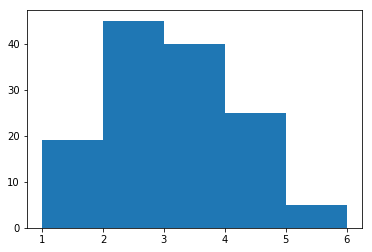

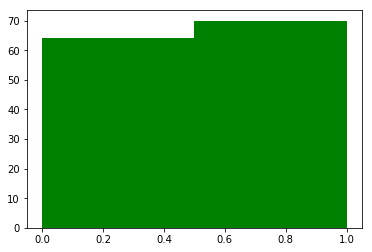

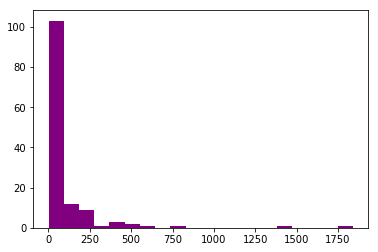

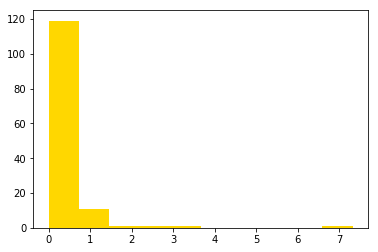

In [18]:
#full_data.hist(column='variable', bins = 5)
plt.hist(full_data.variable, bins = 5)
plt.show()

plt.hist(full_data.binary_label, bins = 2, color='green')
plt.show()

plt.hist(full_data.n_tweets, bins = 20, color = 'purple')
plt.show()

plt.hist(full_data.ratio, color = 'gold')
plt.show()